In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=22, classes=4, time_points=1001, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [3]:
device = 'cpu'

In [4]:
class PredictFromModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def getPredict(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        self.allPredicted = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                self.allPredicted.append(predicted.item())
                # total += labels.size(0)
                # correct += (predicted == labels).sum().item()

        return self.allPredicted





In [5]:
model = EEGNetModel()
# Load the state dictionary

model.load_state_dict(torch.load("./modelCheckPoint/model.pth", map_location=torch.device('cpu')))

# Set the model to evaluation mode (if not training)
model.eval()

print("Model loaded successfully!")
predModel = PredictFromModel(model)


Model loaded successfully!


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# Assuming you have the EEGNetModel class defined as per your code

# Step 1: Load the model
# If you have saved your model weights as 'eegnet.pth', load it like this:
# model = torch.load('eegnet.pth')  # If you have saved the entire model
model = EEGNetModel(chans=22, classes=4, time_points=1001)  # If you want to create the model and load weights separately

# If you have only saved the model state_dict:
# model.load_state_dict(torch.load('eegnet.pth'))
model.eval()  # Set the model to evaluation mode

# Step 2: Create a random sample
# Create a random sample with the expected input shape
n_samples = 1  # We want to generate a single sample
n_channels = 22  # 22 EEG channels
n_timepoints = 1001  # Time points

# Randomly generate EEG data (values typically in the range of -100 to 100 µV)
random_sample = np.random.randn(n_samples, 1, n_channels, n_timepoints).astype(np.float32)  # Single channel, 22 channels, 1001 time points

# Convert the random sample to a PyTorch tensor
random_sample_tensor = torch.from_numpy(random_sample)

# Step 3: Pass the random sample through the model to get predictions
with torch.no_grad():  # Disable gradient computation during inference
    output = model(random_sample_tensor)

# Step 4: Interpret the output
# The output is raw logits, so apply softmax to get probabilities
probabilities = torch.softmax(output, dim=1)

# Get the predicted class (the index of the maximum probability)
predicted_class = torch.argmax(probabilities, dim=1)

# Print the predicted class
print(f"Predicted class: {predicted_class.item()}")  # Print the predicted class




Predicted class: 3


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13608\3722001913.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


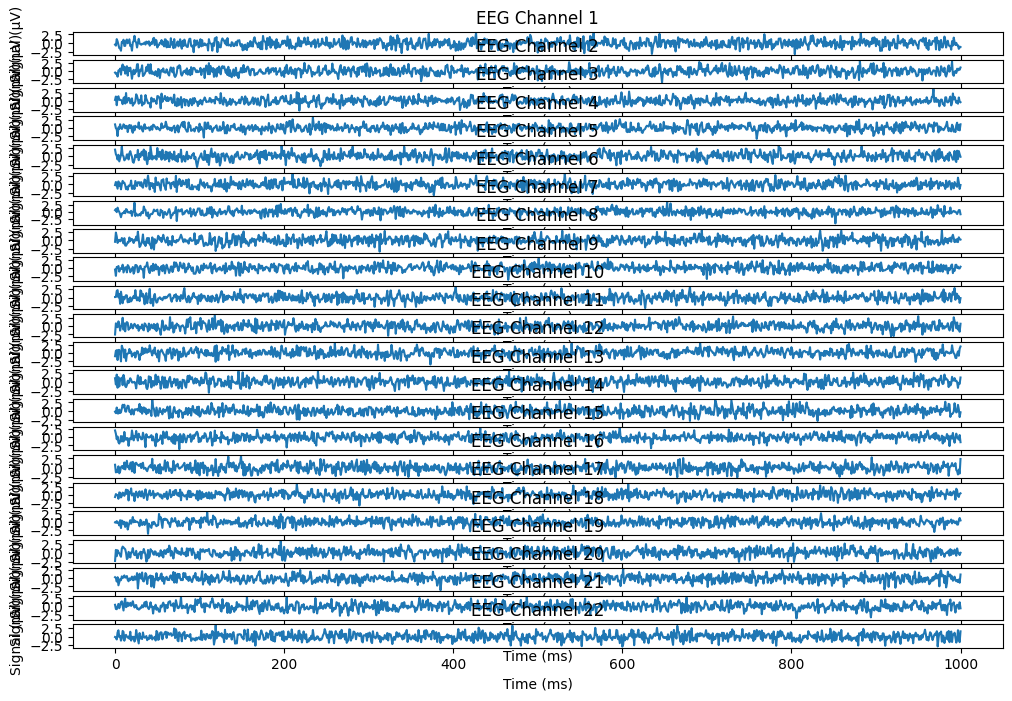

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming random_sample_tensor is your generated random sample with shape (1, 1, 22, 1001)
# We'll use the random sample generated previously
n_samples = 1  # Single sample
n_channels = 22  # 22 EEG channels
n_timepoints = 1001  # Time points

# Generate random EEG data (values typically in the range of -100 to 100 µV)
random_sample = np.random.randn(n_samples, 1, n_channels, n_timepoints).astype(np.float32)  # (1, 1, 22, 1001)
random_sample_tensor = torch.from_numpy(random_sample)

# Step 1: Extract the signal for the first EEG channel (e.g., C4 or any channel)
random_signal = random_sample_tensor[0, 0, :, :]  # Extract the 22 channels' signals for the first sample

# Step 2: Plot the random signal for each EEG channel
plt.figure(figsize=(12, 8))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i+1)  # Create a subplot for each EEG channel
    plt.plot(random_signal[i].numpy())  # Plot the signal of the i-th channel
    plt.title(f'EEG Channel {i+1}')  # Title for each subplot (Channel 1, Channel 2, ...)
    plt.xlabel('Time (ms)')
    plt.ylabel('Signal (µV)')
    plt.tight_layout()

# Step 3: Show the plot
plt.show()


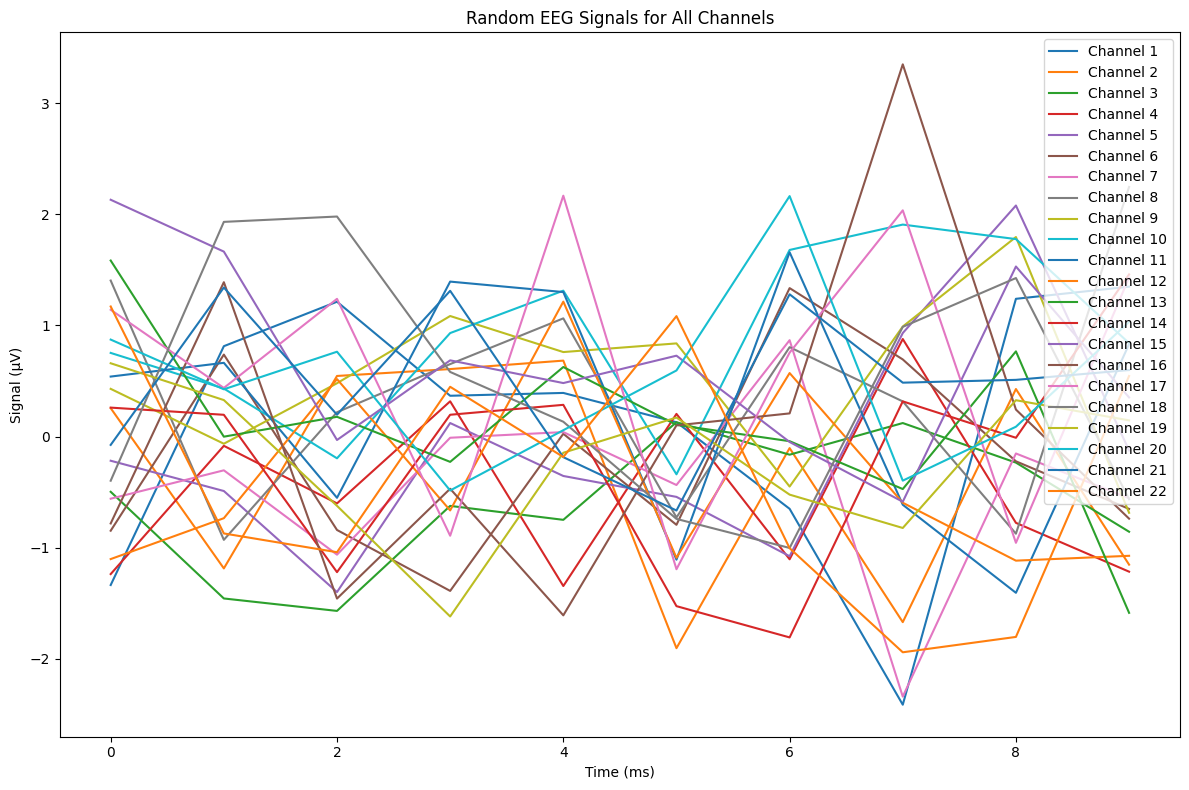

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming random_sample_tensor is your generated random sample with shape (1, 1, 22, 1001)
# We generated a random sample with shape (1, 1, 22, 1001)
n_samples = 1  # Single sample
n_channels = 22  # 22 EEG channels
n_timepoints = 1001  # Time points

# Generate random EEG data (values typically in the range of -100 to 100 µV)
random_sample = np.random.randn(n_samples, 1, n_channels, n_timepoints).astype(np.float32)  # (1, 1, 22, 1001)
random_sample_tensor = torch.from_numpy(random_sample)

# Step 1: Extract the signal for the first EEG sample (for all 22 channels)
random_signal = random_sample_tensor[0, 0, :, :]  # Shape will be (22, 1001)

# Step 2: Plot all EEG channels in the same figure
plt.figure(figsize=(12, 8))

# Plot each channel's signal in the same figure with different colors
for i in range(n_channels):
    plt.plot(random_signal[i].numpy()[:10], label=f'Channel {i+1}')  # Plot the signal of the i-th channel

# Step 3: Add labels and legend
plt.title('Random EEG Signals for All Channels')
plt.xlabel('Time (ms)')
plt.ylabel('Signal (µV)')
plt.legend()  # Add a legend to differentiate channels
plt.tight_layout()

# Step 4: Show the plot
plt.show()
